In [12]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, LayerNormalization, Bidirectional, RepeatVector, TimeDistributed, Add
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from diagnose import evaluate_forecasts



warnings.filterwarnings("ignore")

## 1. Eksploracja Dancych




In [15]:
df = pd.read_csv(r'Amazon Net Income by Quarter.csv')
df = df.head(-32)
df['Category'] = df['Category'].str.strip()

period_strings = df['Category'].str.replace(r'Q([1-4])\s*(\d{4})', r'\2Q\1', regex=True)

period_idx = pd.PeriodIndex(period_strings, freq='Q')

df.index = period_idx.to_timestamp()           

df.index.name = 'Date'  

df = df.drop(columns=['Category'])


## Opis danych

Zbiór danych składa się z jednej zmiennej finansowej zawierającej kwartalne obserwacje:

### **Net Income / Loss (wartość liczbowa, dane kwartalne)**  
Zmienna ta przedstawia zysk netto lub stratę netto osiąganą przez przedsiębiorstwo w każdym kwartale. Jest to kluczowy wskaźnik rentowności, wykorzystywany do analizy:

- efektywności finansowej w czasie,
- trendów wzrostu lub spadku wyników,
- sezonowości i cykliczności działalności,
- stabilności finansowej przedsiębiorstwa,
- identyfikacji potencjalnych czynników ryzyka.

Dane mają postać **szeregu czasowego**, w którym wartości są ułożone chronologicznie i występują w równych odstępach czasowych (co kwartał). Dzięki temu zmienna nadaje się do modelowania metodami prognostycznymi, takimi jak ARIMA, SARIMA, modele wygładzania wykładniczego, modele hybrydowe oraz algorytmy uczenia maszynowego.

---


In [16]:

fig = px.bar(df.reset_index(),
             x='Date',
             y='Net Income/Loss',
             title='Amazon Net Income by Quarter',
             labels={'Net Income/Loss':'Net Income (in Billions)','Date':'Quarter'})

fig.update_traces(marker_color='steelblue', showlegend=False)
fig.update_layout(xaxis_tickformat='%Y-%m', xaxis_tickangle=-45)
fig.show()


## 2. Tesotwanie stacjonarności 


## Analiza Dystrybucji

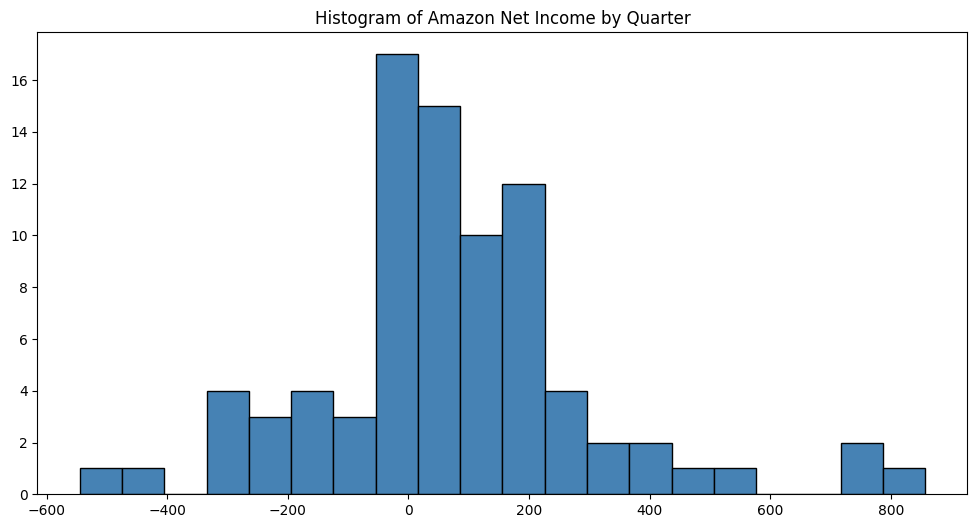

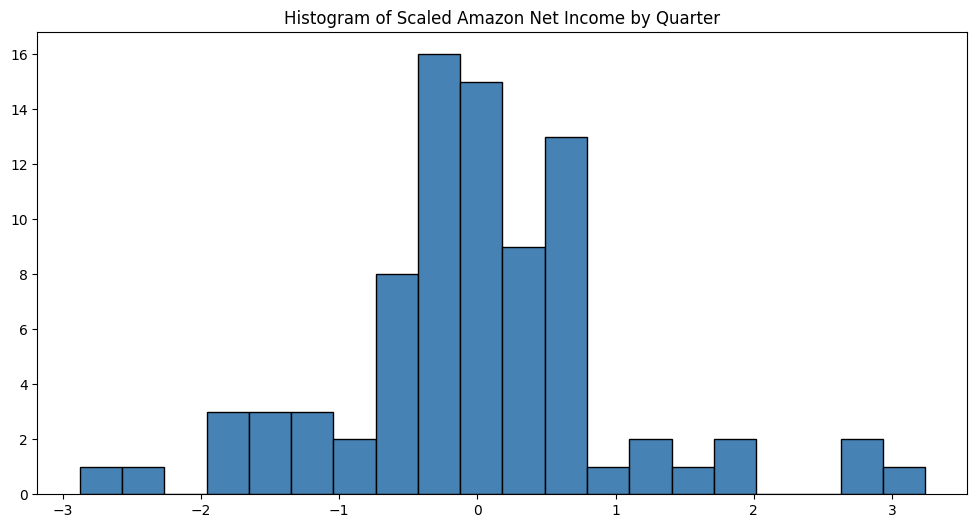

In [17]:
plt.figure(figsize=(12, 6))
plt.hist(df['Net Income/Loss'], bins=20, color='steelblue', edgecolor='black')
plt.title('Histogram of Amazon Net Income by Quarter')
plt.show()

pt = PowerTransformer(method='yeo-johnson')
scaled_data = pt.fit_transform(df)
plt.figure(figsize=(12, 6))
plt.hist(scaled_data, bins=20, color='steelblue', edgecolor='black')
plt.title('Histogram of Scaled Amazon Net Income by Quarter')
plt.show()
scaled_data = pd.DataFrame(scaled_data, index=df.index, columns=df.columns)

dfs = [df, scaled_data]

**Szereg czasowy stacjonarny** to taki szereg, którego własności statystyczne pozostają stałe w czasie.  
Oznacza to, że:

- **wartość oczekiwana (średnia)** jest stała,
- **wariancja** jest stała (nie zależy od czasu),
- **kowariancja/autokowariancja** zależy wyłącznie od opóźnienia (lag), a nie od konkretnego momentu czasu.

W praktyce szereg stacjonarny nie wykazuje trendu ani systematycznych zmian zmienności, a jego struktura statystyczna nie zmienia się wraz z upływem czasu.


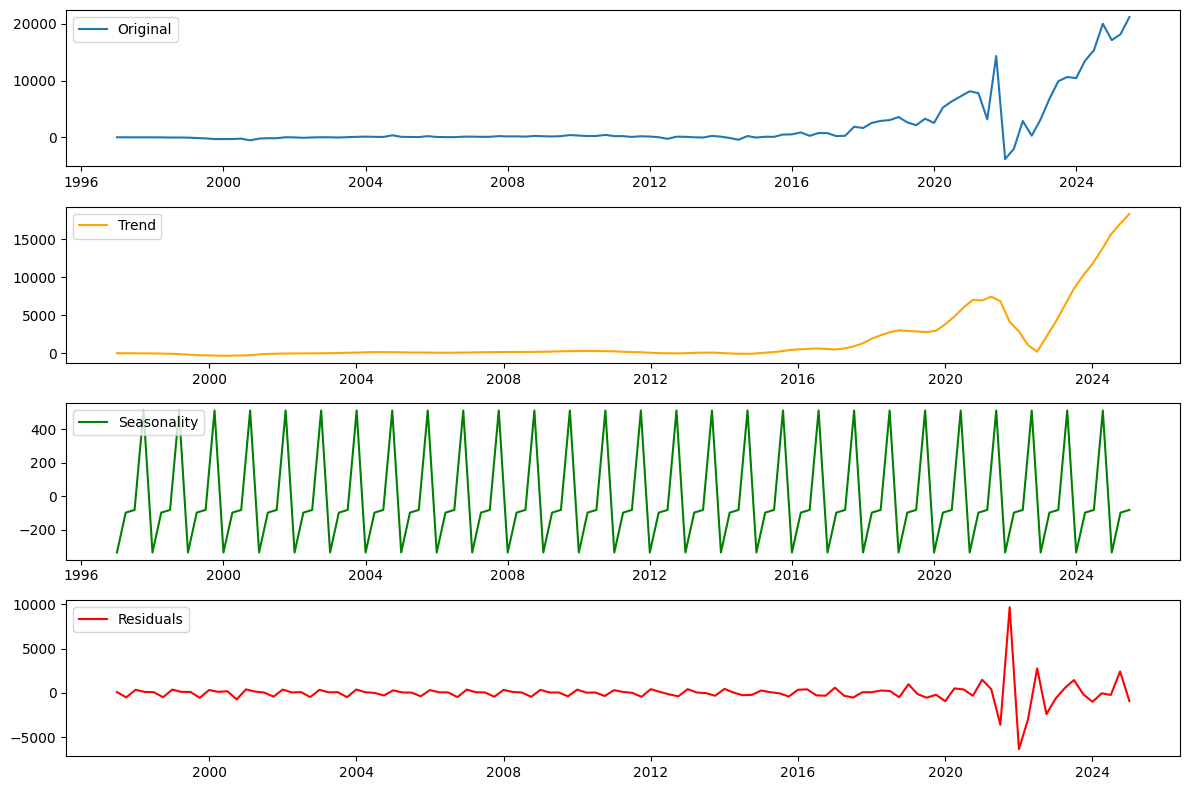

In [10]:
y_basic = df["Net Income/Loss"]

decomposition = seasonal_decompose(y_basic, model='additive', period=4)  

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(y_basic, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## Detrending

In [11]:
kpss_test(y_detrended.diff().dropna(), regression='c')

adf_test(y_detrended.diff().dropna())

zivot_andrews_test(y_detrended.diff().dropna())



NameError: name 'kpss_test' is not defined

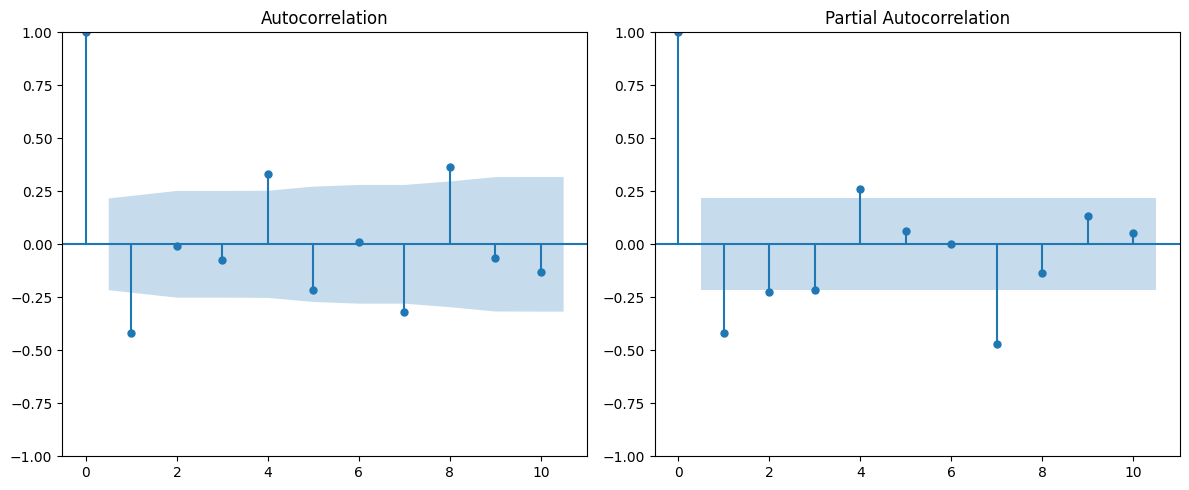

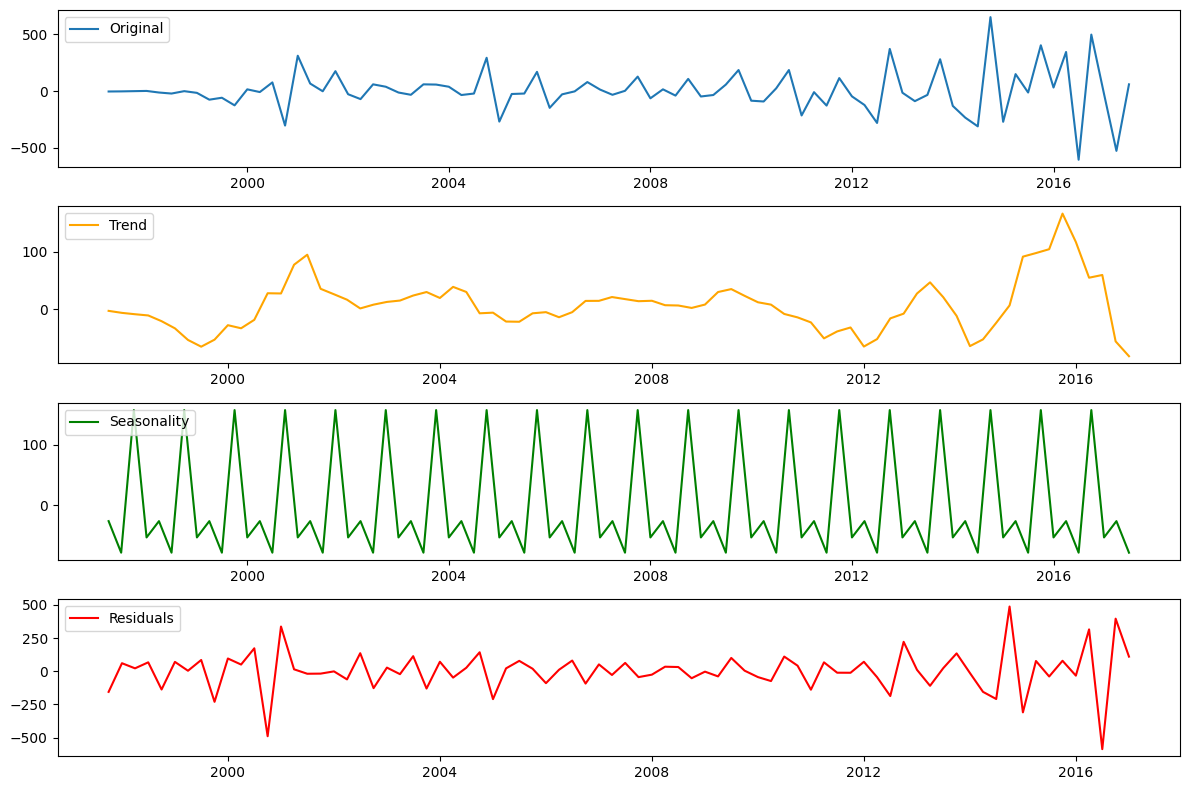

In [ ]:



y_diff = df["Net Income/Loss"].diff().dropna()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(y_diff, ax=plt.gca(), lags=10)

plt.subplot(1, 2, 2)
plot_pacf(y_diff, ax=plt.gca(), lags=10, method="ywm")

plt.tight_layout()
plt.show()

decomposition = seasonal_decompose(y_diff, model='additive', period=4)  

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(y_diff, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

**Wniosek:**  
Na podstawie wyników testów stacjonarności można stwierdzić, że zastosowanie pierwszego różnicowania (**d = 1**) jest odpowiednie dla analizowanego szeregu czasowego w modelu ARIMA.  
Pierwsze różnicowanie skutecznie eliminuje niestacjonarność, stabilizując średnią i umożliwiając poprawne modelowanie procesów autoregresyjnych.


In [ ]:
from diagnose import rolling_forecast_arima
predictions = []
best_row = best_orders['Data 0']
start_index = int(0.6 * len(dfs[0]))

for i in range(3):
    print(f"\nRolling Forecast ARIMA on Data {i}:")
    best_row = best_orders[f'Data {i}']

    train = dfs[i][:start_index].values
    test = dfs[i][start_index:].values
    if i == 1:
        predictions.append(rolling_forecast_arima(train, test, best_row, start_index, dfs[i], scaler=pt))
    else:
        predictions.append(rolling_forecast_arima(train, test, best_row, start_index, dfs[i], scaler=None))

ImportError: cannot import name 'rolling_forecast_arima' from 'diagnose' (c:\Users\kawam\Desktop\repo\stochastyczna prezentacja\diagnose.py)

In [ ]:
import plotly.graph_objects as go

x_start = len(test) - len(pred_lstm) 
x_pred = list(range(x_start, x_start + len(pred_lstm)))

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=test,
    mode='lines',
    name='Actual Test',
    line=dict(color='black')
))

fig.add_trace(go.Scatter(
    x=x_pred,
    y=pred_lstm.flatten(),
    mode='lines',
    name='Predicted LSTM',
    line=dict(color='blue', dash='dash')
))

for i, (pred, name, color) in enumerate(zip(predictions, 
                                            ['Predicted ARIMA', 'Predicted ARIMA scaled', 'Predicted ARIMA trend removed'],
                                            ['red', 'cyan', 'green'])):
    fig.add_trace(go.Scatter(
        y=pred,
        mode='lines',
        name=name,
        line=dict(color=color, dash='dash'),
        visible=True  # Change to 'legendonly' if you want them hidden initially
    ))

# Layout
fig.update_layout(
    title="ARIMA Backtest vs LSTM Forecast",
    xaxis_title="Time Index",
    yaxis_title="Net Income/Loss",
    template="plotly_white",
    legend=dict(
        title="Click to toggle",
        itemclick="toggle",   # default behavior: click to toggle visibility
        itemdoubleclick="toggleothers"  # double-click isolates trace
    )
)

fig.show()

NameError: name 'test' is not defined